# Evapotranspiration Notebook

This notebook is being used to analyze evapotranspiration in the area surrounding Lake Malawi.

Based on https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/#Analyzing-STAC-Metadata

## Notes

The planetary computer catalog uses signed URLs. If errors occur, re-run this notebook from the top to get new signatures. (The signatures expire)

In [74]:
from collections import defaultdict
import geopandas
import json
import matplotlib.pyplot as plt
import numpy as np
import pystac_client
import planetary_computer
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from shapely.geometry import shape
from shapely.ops import transform
import pyproj

In [62]:
# File helpers

def input_path(filename):
  return f"../data/input/{filename}"

def output_path(filename):
  return f"../data/output/{filename}"

In [63]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Get data

We are going to get data from the Modis 16A3GF-061 collection. See:

- https://planetarycomputer.microsoft.com/api/stac/v1/collections/modis-16A3GF-061
- https://planetarycomputer.microsoft.com/explore?c=25.1977%2C-5.0190&z=5.62&v=2&d=modis-16A3GF-061&m=Most+recent&r=Total+evapotranspiration+yearly+500m+%28kg%2Fm²%2Fyear%29&s=false%3A%3A100%3A%3Atrue&sr=desc&ae=0

In [65]:
time_range = "2017-01-01/2024-12-31"

with open(output_path("lake_malawi_expanded_25km.json"), 'r') as f:
    malawi_data = json.load(f)

area_of_interest = malawi_data["geometry"]

search = catalog.search(
    collections=["modis-16A3GF-061"], intersects=area_of_interest, datetime=time_range
)
items = search.item_collection()
len(items)

32

In [66]:
df = geopandas.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
df

,geometry,created,updated,datetime,platform,proj:wkt2,proj:shape,instruments,end_datetime,modis:tile-id,proj:geometry,proj:transform,start_datetime,modis:vertical-tile,modis:horizontal-tile
0,"POLYGON ((30.3485 -9.9655, 40.629 -9.9553, 42....",2025-01-20T05:49:01Z,2025-01-19T23:52:49.658000Z,None,,"PROJCS[""unnamed"",GEOGCS[""Unknown datum based u...","[2400, 2400]",[],2024-12-31T23:59:59Z,51021010,"{'type': 'Polygon', 'coordinates': [[[4447802....","[463.3127165279167, 0.0, 3335851.559, 0.0, -46...",2024-01-01T00:00:00Z,10,21
1,"POLYGON ((29.8879 0, 40.0119 0.0034, 40.624 -9...",2025-01-20T05:25:28Z,2025-01-19T23:28:49.577000Z,None,,"PROJCS[""unnamed"",GEOGCS[""Unknown datum based u...","[2400, 2400]",[],2024-12-31T23:59:59Z,51021009,"{'type': 'Polygon', 'coordinates': [[[4447802....","[463.3127165279167, 0.0, 3335851.559, 0.0, -46...",2024-01-01T00:00:00Z,9,21
2,"POLYGON ((30.3485 -9.9655, 40.629 -9.9553, 42....",2025-01-20T04:09:07Z,2025-01-19T22:12:58.494000Z,None,,"PROJCS[""unnamed"",GEOGCS[""Unknown datum based u...","[2400, 2400]",[],2024-12-31T23:59:59Z,51021010,"{'type': 'Polygon', 'coordinates': [[[4447802....","[463.3127165279167, 0.0, 3335851.559, 0.0, -46...",2024-01-01T00:00:00Z,10,21
3,"POLYGON ((29.8879 0, 40.0119 0.0034, 40.624 -9...",2025-01-20T04:16:32Z,2025-01-19T22:20:58.992000Z,None,,"PROJCS[""unnamed"",GEOGCS[""Unknown datum based u...","[2400, 2400]",[],2024-12-31T23:59:59Z,51021009,"{'type': 'Polygon', 'coordinates': [[[4447802....","[463.3127165279167, 0.0, 3335851.559, 0.0, -46...",2024-01-01T00:00:00Z,9,21
4,"POLYGON ((31.79884 -20.00992, 30.34848 -9.9655...",2024-02-09T22:00:03Z,2024-02-09T16:04:42.130000Z,None,aqua,"PROJCS[""unnamed"",GEOGCS[""Unknown datum based u...","[2400, 2400]",[modis],2023-12-31T23:59:59Z,51021010,"{'type': 'Polygon', 'coordinates': [[[4447802....","[463.3127165279167, 0.0, 3335851.559, 0.0, -46...",2023-01-01T00:00:00Z,10,21
5,"POLYGON ((30.34497 -10.00304, 29.88785 -3.8508...",2024-02-09T21:27:03Z,2024-02-09T15:33:30.558000Z,None,aqua,"PROJCS[""unnamed"",GEOGCS[""Unknown datum based u...","[2400, 2400]",[modis],2023-12-31T23:59:59Z,51021009,"{'type': 'Polygon', 'coordinates': [[[4447802....","[463.3127165279167, 0.0, 3335851.559, 0.0, -46...",2023-01-01T00:00:00Z,9,21
6,"POLYGON ((31.79884 -20.00992, 30.34848 -9.9655...",2024-02-07T16:15:07Z,2024-02-07T13:01:12.098000Z,None,terra,"PROJCS[""unnamed"",GEOGCS[""Unknown datum based u...","[2400, 2400]",[modis],2023-12-31T23:59:59Z,51021010,"{'type': 'Polygon', 'coordinates': [[[4447802....","[463.3127165279167, 0.0, 3335851.559, 0.0, -46...",2023-01-01T00:00:00Z,10,21
7,"POLYGON ((30.34497 -10.00304, 29.88785 -3.8508...",2024-02-07T15:06:39Z,2024-02-07T13:01:01.584000Z,None,terra,"PROJCS[""unnamed"",GEOGCS[""Unknown datum based u...","[2400, 2400]",[modis],2023-12-31T23:59:59Z,51021009,"{'type': 'Polygon', 'coordinates': [[[4447802....","[463.3127165279167, 0.0, 3335851.559, 0.0, -46...",2023-01-01T00:00:00Z,9,21
8,"POLYGON ((30.3485 -9.9655, 40.629 -9.9553, 42....",2023-01-29T23:54:26Z,2023-05-17T00:12:24.351000Z,None,,"PROJCS[""unnamed"",GEOGCS[""Unknown datum based u...","[2400, 2400]",[],2022-12-31T23:59:59Z,51021010,"{'type': 'Polygon', 'coordinates': [[[4447802....","[463.3127165279167, 0.0, 3335851.559, 0.0, -46...",2022-01-01T00:00:00Z,10,21
9,"POLYGON ((29.8879 0, 40.0119 0.0034, 40.624 -9...",2023-01-29T23:54:17Z,2023-05-17T00:12:31.427000Z,None,,"PROJCS[""unnamed"",GEOGCS[""Unknown datum based u...","[2400, 2400]",[],2022-12-31T23:59:59Z,51021009,"{'type': 'Polygon', 'coordinates': [[[4447802....","[463.3127165279167, 0.0, 3335851.559, 0.0, -46...",2022-01-01T00:00:00Z,9,21


Check the available assets

In [67]:
print(items[0].assets.keys())

dict_keys(['hdf', 'ET_500m', 'LE_500m', 'PET_500m', 'PLE_500m', 'metadata', 'ET_QC_500m', 'tilejson', 'rendered_preview'])


asdf

In [ ]:
from collections import defaultdict

items_by_year = defaultdict(list)
for item in items:
    year = item.properties["start_datetime"][:4]
    items_by_year[year].append(item)

et_data_by_year = {}

years_list = []
means = []
mins = []
maxs = []
p25_list = []
p75_list = []

for year, year_items in items_by_year.items():
    print(f"Processing {year} with {len(year_items)} tiles...")
    
    datasets = []
    for item in year_items:
        et_asset = item.assets['ET_500m']
        et_href = et_asset.href
        datasets.append(rasterio.open(et_href))
    
    first_crs = datasets[0].crs
    first_nodata = datasets[0].nodata
    first_profile = datasets[0].profile.copy()
    
    merged_data, merged_transform = merge(datasets)
    
    for ds in datasets:
        ds.close()
    
    # Now mask to area of interest
    area_of_interest_shape = shape(area_of_interest)
    transformer = pyproj.Transformer.from_crs("EPSG:4326", first_crs, always_xy=True)
    area_of_interest_reprojected = transform(transformer.transform, area_of_interest_shape)
    
    # Create a temporary profile for masking
    temp_profile = first_profile
    temp_profile.update({
        'height': merged_data.shape[1],
        'width': merged_data.shape[2],
        'transform': merged_transform
    })
    
    # Mask the merged data with 25km area surrounding Lake Malawi
    from rasterio.io import MemoryFile
    with MemoryFile() as memfile:
        with memfile.open(**temp_profile) as mem_dataset:
            mem_dataset.write(merged_data)
            masked_data, masked_transform = mask(
                mem_dataset,
                [area_of_interest_reprojected],
                crop=True,
                nodata=first_nodata
            )
    
    et_data_by_year[year] = {
        'data': masked_data,
        'transform': masked_transform,
        'profile': temp_profile
    }
    
    flat_data = masked_data.flatten()
    valid_data = flat_data[flat_data != first_nodata]

    # Filter out unreasonably high values (MODIS is scaled to a valid integer of 0 to 32767)
    # See: https://mcst.gsfc.nasa.gov/l1b-algorithm-overview
    valid_data = valid_data[(valid_data >= 0) & (valid_data < 32767)]

    if len(valid_data) > 0:
        scaled_data = valid_data * 0.1
        print(f"{year}: Mean ET = {scaled_data.mean():.2f} kg/m²/year")
        years_list.append(int(year))
        means.append(scaled_data.mean())
        mins.append(scaled_data.min())
        maxs.append(scaled_data.max())
        p25_list.append(np.percentile(scaled_data, 25))
        p75_list.append(np.percentile(scaled_data, 75))
    else:
        print(f"{year}: No valid data")

Processing 2024 with 4 tiles...
2024: Mean ET = 799.41 kg/m²/year
Processing 2023 with 4 tiles...
2023: Mean ET = 827.84 kg/m²/year
Processing 2022 with 4 tiles...
2022: Mean ET = 822.33 kg/m²/year
Processing 2021 with 4 tiles...
2021: Mean ET = 789.08 kg/m²/year
Processing 2020 with 4 tiles...
2020: Mean ET = 818.99 kg/m²/year
Processing 2019 with 4 tiles...
2019: Mean ET = 847.40 kg/m²/year
Processing 2018 with 4 tiles...
2018: Mean ET = 846.55 kg/m²/year
Processing 2017 with 4 tiles...
2017: Mean ET = 855.81 kg/m²/year


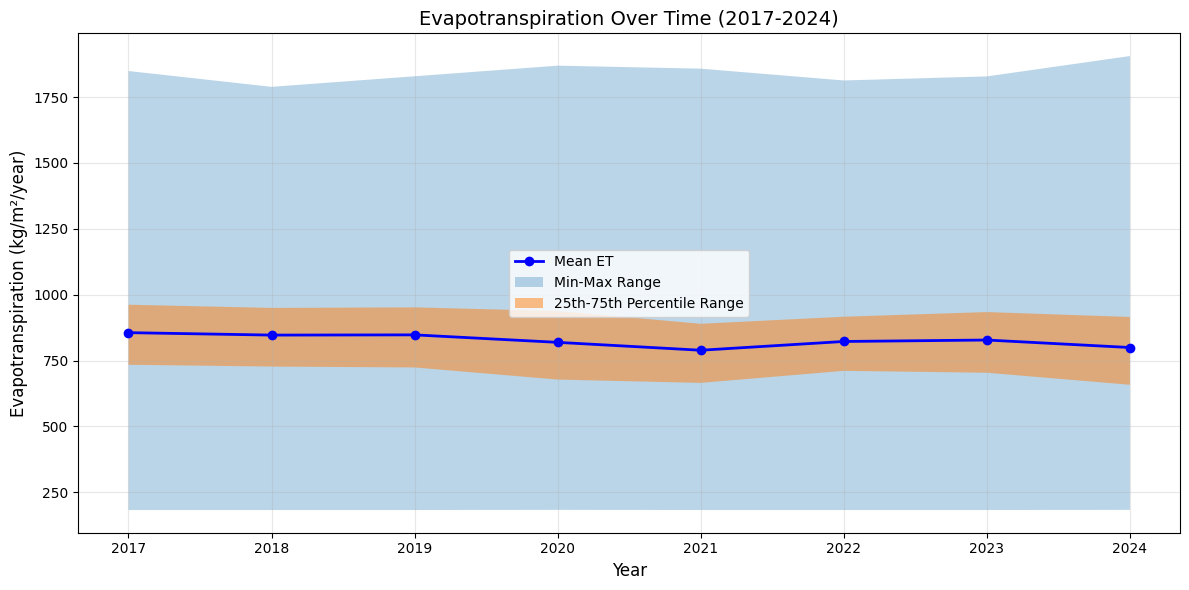

In [78]:
sorted_indices = np.argsort(years_list)
years_sorted = np.array(years_list)[sorted_indices]
means_sorted = np.array(means)[sorted_indices]
mins_sorted = np.array(mins)[sorted_indices]
maxs_sorted = np.array(maxs)[sorted_indices]
p25_sorted = np.array(p25_list)[sorted_indices]
p75_sorted = np.array(p75_list)[sorted_indices]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(years_sorted, means_sorted, marker='o', label='Mean ET', linewidth=2, color='blue')
ax.fill_between(years_sorted, mins_sorted, maxs_sorted, alpha=0.3, label='Min-Max Range')
ax.fill_between(years_sorted, p25_sorted, p75_sorted, alpha=0.5, label="25th-75th Percentile Range")
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Evapotranspiration (kg/m²/year)', fontsize=12)
ax.set_title('Evapotranspiration Over Time (2017-2024)', fontsize=14)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()